In [1]:
import pandas as pd
import numpy as np
from convlstm import ConvLSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
from skimage import io
from sklearn.model_selection import train_test_split



In [2]:
data_train = pd.read_csv("dataset/data_skill_corner/label_edit.txt",skiprows=1,
                         names=['frame','intention_type','current_velocity','steering_wheel_angle','dlm'],
                         sep='\s+')
data_train = data_train.to_numpy()


#print (y_train.shape,y_test.shape)        
root_dir = 'dataset/data_skill_corner/rgb_0/'


In [6]:
class RGBDataset():
    """Face Landmarks dataset."""
        
    def __init__(self, nb_frames,root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv("dataset/data_skill_corner/label_edit.txt",skiprows=1,
                                       names=['frame','intention_type','current_velocity',
                                              'steering_wheel_angle','dlm'],sep='\s+').to_numpy()
        self.data_train,_ = train_test_split(self.data,test_size = 0.2, shuffle=False)
        self.nb_frames = nb_frames
        self.root_dir = root_dir


    def __len__(self):
        return len(self.data_train) - self.nb_frames*3
        #return 200
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        X_train_t = [io.imread(os.path.join(self.root_dir,str(self.data_train[idx+i,0])+'.jpg')).astype(np.float32) for i in range (self.nb_frames)] 
        X_train = np.stack(X_train_t, axis=0)        
        X_train1 = np.moveaxis(X_train,-1,1)
        
        y_train = self.data_train[idx+self.nb_frames,2:4].astype(np.float32)
        y_train1 = y_train.reshape(1,2)
        sample = {'X_train': X_train1, 'y_train': y_train1}

        return sample

In [7]:
class RGBDataset_test():
    """Face Landmarks dataset."""
        
    def __init__(self, nb_frames,root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv("dataset/data_skill_corner/label_edit.txt",skiprows=1,
                                       names=['frame','intention_type','current_velocity',
                                              'steering_wheel_angle','dlm'],sep='\s+').to_numpy()
        self.data_train,self.data_test= train_test_split(self.data,test_size = 0.2, shuffle=False)
        self.nb_frames = nb_frames
        self.root_dir = root_dir


    def __len__(self):
        return len(self.data_test) - self.nb_frames
        #return 200
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        X_test_t = [io.imread(os.path.join(self.root_dir,str(self.data_test[idx+i,0])+'.jpg')).astype(np.float32) for i in range (self.nb_frames)] 
        X_test = np.stack(X_test_t, axis=0)        
        X_test1 = np.moveaxis(X_test,-1,1)
        
        y_test = self.data_test[idx+self.nb_frames,2:4].astype(np.float32)
        y_test1 = y_test.reshape(1,2)
        sample = {'X_test': X_test1, 'y_test': y_test1}

        return sample

In [8]:
NUM_FRAMES=5

rgb_train = RGBDataset(NUM_FRAMES,'dataset/data_skill_corner/rgb_0/') #frame
rgb_test = RGBDataset_test(NUM_FRAMES,'dataset/data_skill_corner/rgb_0/')
sample = rgb_test[0]
#print (sample['X_test'].shape) #(5, 3, 224, 224)
#print (sample['y_test'].shape) #(1, 2)
from torch.utils.data import Dataset, DataLoader
dataloader_train = DataLoader(rgb_train, batch_size=8,
                        shuffle=False, num_workers=4)
dataloader_test = DataLoader(rgb_test, batch_size=8,
                        shuffle=False, num_workers=4)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        global NUM_FRAMES
        #self.conv1 = ConvLSTM(input_channels=1, hidden_channels=[64, 32, 32], kernel_size=3, step=5,
        #           effective_step=[4]).cuda()
        
        self.maxpool= nn.MaxPool3d((1,5,5),stride=(1,3,3))
        self.BD1 = nn.BatchNorm2d(32)
        self.BD2 = nn.BatchNorm2d(16)
        self.drop = nn.Dropout(p=0.3)
        self.conv1 = ConvLSTM(input_size = (74,74), input_dim = 3, hidden_dim = [64, 32, 32], 
                              kernel_size = (3,3), num_layers = 3, batch_first=True)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3,stride=2)
        self.fc1 = nn.Linear(NUM_FRAMES*16*9*9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        
        x = self.maxpool(x)
        #print (x.shape)
        x = self.conv1(x)     
        x = self.BD1(x[0][0])    
        x = F.relu(F.max_pool2d(x,2))  
        #x = self.drop(x)
        x = self.BD2(self.conv2(x))  
        x = F.relu(F.max_pool2d(x,2))  
        
        x = x.view(1,-1)
        #x = self.drop(x)
        x = F.relu(self.fc1(x))    
        
        
        x = F.relu(self.fc2(x))
        x = self.fc3(x).reshape(-1,1,2)
        return x


net = Net().cuda()

print(net)

print(sum(p.numel() for p in net.parameters()))

Net(
  (maxpool): MaxPool3d(kernel_size=(1, 5, 5), stride=(1, 3, 3), padding=0, dilation=1, ceil_mode=False)
  (BD1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BD2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.3, inplace=False)
  (conv1): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(67, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=6480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
1131974


0.0


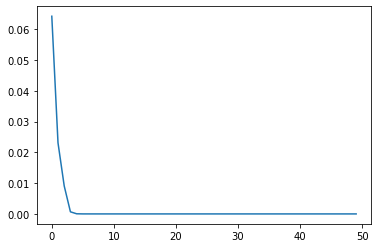

In [16]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
net1 = Net().cuda()
p = Variable(torch.randn(1,5, 3, 224, 224)).cuda()
q = Variable(torch.randn(1,1,2)).cuda()
#print (out.shape)

criterion = nn.MSELoss()
optimizer = optim.SGD(net1.parameters(), lr=0.01)
#optimizer = optim.Adam(net.parameters(), lr=0.01,betas=(0.9,0.99))
loss_values = []
for i in range (50):
    optimizer.zero_grad()
     
    out = net1(p)

    los = criterion(out, q)
      
    los.backward()
    #print(i,los)
    optimizer.step()
    
    loss_values.append(los.item())
#del p,q,out,los
#torch.cuda.empty_cache()     
plt.plot(loss_values)     
print(loss_values[-1])

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
# create your optimizer
net = Net().cuda()
criterion = nn.MSELoss()
#optimizer = optim.Adam(net.parameters(), lr=0.005,betas=(0.9,0.99))
optimizer = optim.SGD(net.parameters(), lr=0.0005)
loss_values = []
test_values = []
for epoch in range(200):  # loop over the dataset multiple times
    
    running_loss = 0.0
    running_test_loss = 0.0
    for i,data in enumerate(dataloader_train,0):
        
        # get the inputs; data is a list of [inputs, labels]
        X_t, y_t = data['X_train'].cuda(),data['y_train'].cuda()
        
        #print(X_t) #torch.Size([10, 5, 3, 224, 224]) torch.Size([10, 1, 2])
        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        for j in range (len(X_t)):
            outputs = net(X_t[j].reshape(1,NUM_FRAMES,3,224,224))
            if j == 0:
                loss = criterion(outputs, y_t[j].reshape(1,1,2))
                #print(loss)
                
            else:
                loss += criterion(outputs, y_t[j].reshape(1,1,2))

        loss.backward()
        optimizer.step()       

        # print statistics
        
        running_loss += loss.item()
    loss_values.append(running_loss)
                   
    with torch.no_grad():        
        for i,data in enumerate(dataloader_test,0):
            X_test, y_test = data['X_test'].cuda(),data['y_test'].cuda()
            for j in range (len(X_test)):
                out_test = net(X_test[j].reshape(1,NUM_FRAMES,3,224,224))
                if j ==0:
                    test_loss = criterion(out_test, y_test[j].reshape(1,1,2))
                else:
                    test_loss += criterion(out_test, y_test[j].reshape(1,1,2))
                    
            running_test_loss += test_loss.item()

        test_values.append(running_test_loss)
       
    
    print('[epoch%d] running_loss: %.3f, test_loss:%.3f' %(epoch + 1, running_loss, running_test_loss))

          

    #plt.plot(loss_values) 
    #plt.plot(test_values) 
   
    


print('Finished Training')


[epoch1] running_loss: 277.962, test_loss:97.752
[epoch2] running_loss: 232.092, test_loss:76.860
[epoch3] running_loss: 183.158, test_loss:62.427
[epoch4] running_loss: 138.492, test_loss:54.603
[epoch5] running_loss: 115.672, test_loss:47.883
[epoch6] running_loss: 99.002, test_loss:41.837
[epoch7] running_loss: 87.871, test_loss:38.337
[epoch8] running_loss: 80.605, test_loss:36.573
[epoch9] running_loss: 74.839, test_loss:34.445
[epoch10] running_loss: 69.940, test_loss:33.888
[epoch11] running_loss: 66.092, test_loss:33.097
[epoch12] running_loss: 63.143, test_loss:32.639
[epoch13] running_loss: 60.726, test_loss:32.669
[epoch14] running_loss: 58.448, test_loss:32.197
[epoch15] running_loss: 56.437, test_loss:32.335
[epoch16] running_loss: 54.455, test_loss:31.923
[epoch17] running_loss: 52.721, test_loss:31.763
[epoch18] running_loss: 51.267, test_loss:31.499
[epoch19] running_loss: 49.923, test_loss:31.296
[epoch20] running_loss: 48.586, test_loss:31.159
[epoch21] running_loss: 

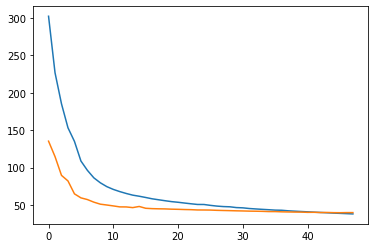

In [28]:
plt.plot(loss_values) 
plt.plot(test_values) 

In [29]:
torch.save(net.state_dict(), 'dataset/data_skill_corner/model_004')

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval() 